In [1]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import math
import hamiltorch
import torch.distributions as dist

In [2]:
model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

In [3]:
# find total number of parameters in model
num_params = 0
for param in model.parameters():
    num_params += param.numel()
print(f"Total number of parameters in model: {num_params}")

Total number of parameters in model: 33


In [4]:
X, y = make_circles(n_samples=100, noise=0.02, random_state=42)

In [5]:
X = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(y.astype(np.float32))

In [6]:
def negative_log_likelihood(parameters):
    params_list = hamiltorch.util.unflatten(model, parameters)
    w1, b1, w2, b2 = params_list
    res=0
    for i in range(len(X)):
        logit = F.linear(X[i], w1, b1)
        logit = F.relu(logit)
        logit = F.linear(logit, w2, b2)
        res+=torch.distributions.Bernoulli(logits=logit).log_prob(y[i])
    return -res

def negative_log_prior (parameters):
    normal_dist = dist.Normal(0, 1)
    return -normal_dist.log_prob(parameters).sum()

def negative_log_joint(parameters):
    return negative_log_likelihood(parameters) + negative_log_prior(parameters)

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for i in range(2000):
    optimizer.zero_grad()
    loss = negative_log_joint(hamiltorch.util.flatten(model))
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Epoch {i}, loss {loss.item()}')

Epoch 0, loss 101.99897003173828
Epoch 100, loss 99.36163330078125
Epoch 200, loss 98.96652221679688
Epoch 300, loss 98.59855651855469
Epoch 400, loss 98.03384399414062
Epoch 500, loss 97.72466278076172
Epoch 600, loss 97.5992431640625
Epoch 700, loss 97.52751159667969
Epoch 800, loss 97.50927734375
Epoch 900, loss 97.50784301757812
Epoch 1000, loss 97.50331115722656
Epoch 1100, loss 97.49835205078125
Epoch 1200, loss 97.50025939941406
Epoch 1300, loss 97.49913024902344
Epoch 1400, loss 97.49783325195312
Epoch 1500, loss 97.4990234375
Epoch 1600, loss 97.49832153320312
Epoch 1700, loss 97.49923706054688
Epoch 1800, loss 97.49632263183594
Epoch 1900, loss 97.49688720703125


/Users/arunreddy/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678402353079/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


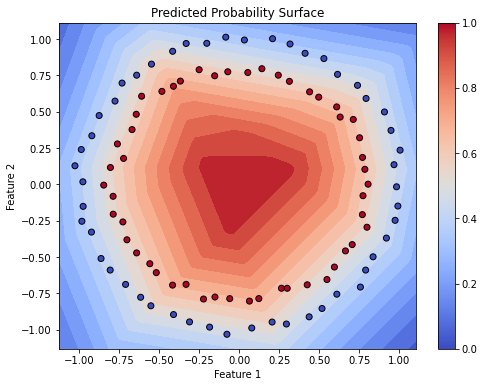

In [8]:
from matplotlib import pyplot as plt
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

x_range = torch.linspace(x_min, x_max, 100)
y_range = torch.linspace(y_min, y_max, 100)
xx, yy = torch.meshgrid(x_range, y_range)
grid_points = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)

# Calculate predicted probability surface using MAP estimate
with torch.no_grad():
    logits = model(grid_points)
    predicted_prob = torch.sigmoid(logits).reshape(xx.shape).numpy()

# Plot the predicted probability surface
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, predicted_prob, levels=20, cmap='coolwarm')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', linewidths=1)
plt.title('Predicted Probability Surface')
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [9]:
negative_log_joint(hamiltorch.util.flatten(model))

tensor([97.4985], grad_fn=<AddBackward0>)

In [10]:
from torch.autograd.functional import hessian

In [11]:
input = hamiltorch.util.flatten(model)
output = hessian(negative_log_joint, input)
output

tensor([[ 1.1218e+01, -1.5158e+00,  5.6661e+00,  ...,  3.7823e-01,
          0.0000e+00, -7.8679e+00],
        [-1.5158e+00,  1.0869e+01,  5.4420e-01,  ...,  1.4066e+00,
          0.0000e+00,  6.8401e+00],
        [ 5.6661e+00,  5.4420e-01,  6.7977e+00,  ...,  1.7798e-02,
          2.5802e-01, -5.1319e+00],
        ...,
        [ 3.7823e-01,  1.4066e+00,  1.7798e-02,  ...,  7.7364e+00,
          9.5240e-01,  7.6380e+00],
        [ 0.0000e+00,  0.0000e+00,  2.5802e-01,  ...,  9.5240e-01,
          2.3738e+00,  3.2867e+00],
        [-7.8679e+00,  6.8401e+00, -5.1319e+00,  ...,  7.6380e+00,
          3.2867e+00,  2.5471e+01]])

In [12]:
# invert the output matrix
covariance = torch.inverse(output)
covariance

tensor([[ 0.4349, -0.1294, -0.1509,  ..., -0.0764,  0.3634,  0.2306],
        [-0.1294,  0.3530, -0.0993,  ...,  0.0632,  0.0884, -0.1748],
        [-0.1508, -0.0993,  1.0368,  ...,  0.2139, -1.8441, -0.2257],
        ...,
        [-0.0764,  0.0632,  0.2139,  ...,  0.7104, -0.5084, -0.3537],
        [ 0.3634,  0.0884, -1.8441,  ..., -0.5084,  7.0528,  0.8065],
        [ 0.2306, -0.1748, -0.2257,  ..., -0.3537,  0.8065,  0.8321]])

In [13]:
np.linalg.eigvals(covariance)

array([3.3544022e+01, 2.5995684e+01, 2.8490307e+00, 1.8377976e+00,
       1.1353058e+00, 9.9982828e-01, 9.8845315e-01, 8.2875949e-01,
       1.1986495e-02, 2.3645038e-02, 2.6177911e-02, 8.2361147e-02,
       8.9549854e-02, 3.0439702e-01, 6.3628501e-01, 3.7740049e-01,
       4.0293398e-01, 5.8951610e-01, 4.7330749e-01, 5.2582079e-01,
       4.8690215e-01, 5.0736701e-01, 5.0338078e-01, 4.9882263e-01,
       4.9772462e-01, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00], dtype=float32)

In [14]:
e_11 = covariance[0][0]
e_22 = covariance[1][1]
e_12 = covariance[0][1]
e_21 = covariance[1][0]

covariance_2D = np.array([[e_11, e_12], [e_21, e_22]])

In [15]:
m_0 = input[0]
m_1 = input[1] 

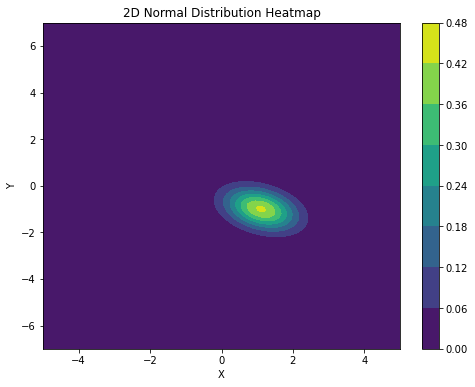

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


# Define the 2D mean vector (mu) and the 2x2 covariance matrix (cov)
mu = np.array([m_0.item(), m_1.item()])
cov = np.array([[e_11, e_12],
                [e_21, e_22]])

# Generate a grid of points to evaluate the PDF
x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-7, 7, 100))
pos = np.dstack((x, y))  # Create a (100, 100, 2) array of (x, y) pairs

# Create a multivariate normal distribution with the given mean and covariance
rv = multivariate_normal(mu, cov)

# Evaluate the PDF at each point on the grid
pdf_values = rv.pdf(pos)

# Create a heatmap of the PDF values
plt.figure(figsize=(8, 6))
plt.contourf(x, y, pdf_values, cmap='viridis')
plt.title('2D Normal Distribution Heatmap')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()